In [1]:
import pandas as pd
all_data = pd.read_csv('hmda_2017_ca_all-records_labels.csv')

/home/mattrimol/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (34,36,38,42,44,46,48) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [2]:
from pandas.api.types import is_numeric_dtype

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import seaborn as sns

# modeling imports
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, StratifiedKFold
from sklearn import metrics
from sklearn import preprocessing, pipeline, decomposition, compose
from sklearn_pandas import DataFrameMapper

import imblearn.under_sampling
import imblearn.over_sampling
import xgboost as xgb

from collections import defaultdict

In [3]:
#Store this to use later on if we want to dig more into interperetablity of results
denials = all_data[['respondent_id', 'denial_reason_name_1', 'denial_reason_name_2', 'denial_reason_name_3']]

all_data.drop([
                'agency_name',
                'agency_code',
                'loan_type',
                'property_type',
                'loan_purpose',
                'owner_occupancy',
                'preapproval',
                'action_taken',
                'msamd',
                'state_name',
                'state_code',
                'county_code',
                'applicant_ethnicity',
                'co_applicant_ethnicity',
                'applicant_race_1',
                'applicant_race_2',
                'applicant_race_3',
                'applicant_race_4',
                'applicant_race_5',
                'co_applicant_race_1',
                'co_applicant_race_2',
                'co_applicant_race_3',
                'co_applicant_race_4',
                'co_applicant_race_5',
                'applicant_sex',
                'co_applicant_sex',
                'purchaser_type',
                'denial_reason_1',
                'denial_reason_2',
                'denial_reason_3',
                'denial_reason_name_1', #Stored in denials table
                'denial_reason_name_2', #Stored in denials table
                'denial_reason_name_3', #Stored in denials table
                'hoepa_status',
                'lien_status',
                'edit_status',
                'edit_status_name',
                'sequence_number',
                'application_date_indicator',
                'rate_spread'],axis=1, inplace=True)

#Only do this if single state and single year
all_data.drop(['as_of_year', 'state_abbr'], axis=1, inplace=True)

#Shortening some strings
all_data.replace('One-to-four family dwelling (other than manufactured housing)',
                 '1 to 4 family (excl. manufactured)', inplace=True)
all_data.replace('Information not provided by applicant in mail, Internet, or telephone application',
                 'Info not provided', inplace=True)

## Subjective Cleaning

In [4]:
# Likely too much complexity to go beyond two race listings
all_data.drop(['applicant_race_name_3',
               'applicant_race_name_4',
               'applicant_race_name_5',
               'co_applicant_race_name_3',
               'co_applicant_race_name_4',
               'co_applicant_race_name_5'], axis=1, inplace=True)

In [5]:
# Filter down to applications accepted or denied (remove preapprovals and incompletes) and make binary
acc_or_den_filter = (all_data['action_taken_name'] == 'Loan originated') |\
                    (all_data['action_taken_name'] == 'Application denied by financial institution')
all_data = all_data[acc_or_den_filter]

all_data['action_taken_name'].replace('Loan originated', 0, inplace=True)
all_data['action_taken_name'].replace('Application denied by financial institution', 1, inplace=True)

In [6]:
#Droping all the entires where we don't have census data
all_data = all_data[all_data['population'].notna()]

In [7]:
#Droping where loan_amount_000s is na
all_data = all_data[all_data['loan_amount_000s'].notna()]

In [8]:
all_data.drop(['county_name', #Too many
               'census_tract_number', #Too many
               'purchaser_type_name',
               'hoepa_status_name', #Most are not HOEPA
               'lien_status_name', #Probably exclude since vast majority are in one category
              ], axis=1, inplace=True)

In [9]:
# Unreported incomes seem to have similar loan amounts as reported incomes
# Droping nulls for now, but consider filling with median. Probably big enough sample to just drop though.
all_data = all_data[all_data['applicant_income_000s'].notna()]

In [10]:
# Null location for Metropolitan Statistical Area/Metropolitan Division calling 'Other'
all_data.loc[all_data['msamd_name'] == np.nan, 'msamd_name'] = 'Other'

In [11]:
#all_data.info()

## Outlier Handling

In [12]:
#Dropping multifamily dwellings
multifamily = all_data['property_type_name'] == 'Multifamily dwelling'
all_data = all_data.drop(all_data[multifamily].index)

In [13]:
# We want to exclude huge purchases and really small ones
# Magic numbers here consider review
loan_amt_filter = (all_data['loan_amount_000s'] > 25) &\
                  (all_data['loan_amount_000s'] < 20000)
all_data = all_data[loan_amt_filter]

## Feature Engineering

In [14]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1015606 entries, 0 to 1710448
Data columns (total 25 columns):
 #   Column                          Non-Null Count    Dtype  
---  ------                          --------------    -----  
 0   respondent_id                   1015606 non-null  object 
 1   agency_abbr                     1015606 non-null  object 
 2   loan_type_name                  1015606 non-null  object 
 3   property_type_name              1015606 non-null  object 
 4   loan_purpose_name               1015606 non-null  object 
 5   owner_occupancy_name            1015606 non-null  object 
 6   loan_amount_000s                1015606 non-null  float64
 7   preapproval_name                1015606 non-null  object 
 8   action_taken_name               1015606 non-null  int64  
 9   msamd_name                      991323 non-null   object 
 10  applicant_ethnicity_name        1015606 non-null  object 
 11  co_applicant_ethnicity_name     1015606 non-null  object 
 12  

In [15]:
# binary column, has coapplicant?
def has_coapp(row):
    if row['co_applicant_sex_name'] == 'No co-applicant':
        return 0
    else:
        return 1
all_data['has_coapplicant'] = all_data.apply(lambda row: has_coapp(row), axis=1)

In [16]:
# 1 if backed by ANY federal agency
def fed_insured(row):
    if row['loan_type_name'] == 'Conventional':
        return 0
    else:
        return 1
all_data['fed_insured'] = all_data.apply(lambda row: fed_insured(row), axis=1)
all_data.drop('loan_type_name', axis=1, inplace=True)

In [17]:
# Loan amount / Income
all_data['loan_amount/applicant_income'] = all_data['loan_amount_000s']/all_data['applicant_income_000s']

## Helper Functions

In [18]:
def get_cols(df):
    '''Print vertical list so you can paste into excel and make notes'''
    for col in df.columns:
        print(col)

In [19]:
def check_feature(df, feature):
    if is_numeric_dtype(df[feature]):
        plt.hist(df[feature])
    else:
        print(df[feature].value_counts())
        ((df[feature].value_counts() / len(df[feature]))*100).sort_values().plot(kind = 'barh')
        plt.xticks(np.arange(0, 100, 5))

In [20]:
def create_model_df(df, features_list):
    return df[features_list + ['action_taken_name']].dropna()

## EDA

In [21]:
for count in all_data['action_taken_name'].value_counts():
    print(count/len(all_data['action_taken_name']))

0.7985842935153987
0.2014157064846013


HUD     611656
CFPB    296284
NCUA     53082
FDIC     26893
OCC      20097
FRS       7594
Name: agency_abbr, dtype: int64


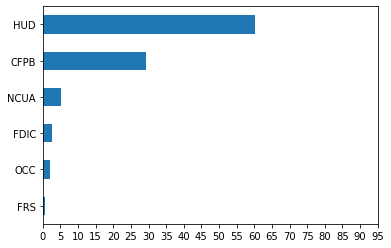

In [22]:
check_feature(all_data, 'agency_abbr')

In [23]:
get_cols(all_data)

respondent_id
agency_abbr
property_type_name
loan_purpose_name
owner_occupancy_name
loan_amount_000s
preapproval_name
action_taken_name
msamd_name
applicant_ethnicity_name
co_applicant_ethnicity_name
applicant_race_name_1
applicant_race_name_2
co_applicant_race_name_1
co_applicant_race_name_2
applicant_sex_name
co_applicant_sex_name
applicant_income_000s
population
minority_population
hud_median_family_income
tract_to_msamd_income
number_of_owner_occupied_units
number_of_1_to_4_family_units
has_coapplicant
fed_insured
loan_amount/applicant_income


## Creating Models

#### Choose features and make a dataframe with those

In [24]:
# Simple bare bones model
features_1 = ['applicant_income_000s', 'fed_insured']
model1 = create_model_df(all_data, features_1)

In [25]:
# Throw more at it
features_2 = ['loan_purpose_name',
              'owner_occupancy_name',
              'loan_amount_000s',
              'applicant_race_name_1',
              'applicant_income_000s',
              'population',
              'minority_population',
              'hud_median_family_income',
              'tract_to_msamd_income',
              'has_coapplicant']
              #'fed_insured']
model2 = create_model_df(all_data, features_2)

In [26]:
features_3 = ['loan_purpose_name', 'owner_occupancy_name', 'loan_amount/applicant_income', 'tract_to_msamd_income']
model3 = create_model_df(all_data, features_3)

In [27]:
features_4 = [#'agency_abbr',
              'property_type_name',
              'loan_purpose_name',
              'owner_occupancy_name',
              #'loan_amount_000s',
              'msamd_name', #Going to be a lot of these
              'applicant_ethnicity_name',
              'applicant_race_name_1',
              'applicant_sex_name',
              #'applicant_income_000s',
              'population',
              'minority_population',
              #'hud_median_family_income', #probably shouldn't include with tract_to_msand_income
              'tract_to_msamd_income',
              #'number_of_owner_occupied_units',
              #'number_of_1_to_4_family_units',
              'has_coapplicant',
              #'fed_insured',
              'loan_amount/applicant_income']
model4 = create_model_df(all_data, features_4)

In [28]:
# Take out any features that shouldn't actually have an effect (assume banks are not discriminating unfairly)
features_5 = [#'agency_abbr',
              'property_type_name',
              'loan_purpose_name',
              'owner_occupancy_name',
              #'loan_amount_000s',
              #'msamd_name', #Going to be a lot of these
              #'applicant_ethnicity_name',
              #'applicant_race_name_1',
              #'applicant_sex_name',
              #'applicant_income_000s',
              #'population',
              #'minority_population',
              #'hud_median_family_income', #probably shouldn't include with tract_to_msand_income
              'tract_to_msamd_income',
              #'number_of_owner_occupied_units',
              #'number_of_1_to_4_family_units',
              'has_coapplicant',
              #'fed_insured',
              'loan_amount/applicant_income']
model5 = create_model_df(all_data, features_5)

In [29]:
# Another simple model
features_6 = [#'agency_abbr',
              #'property_type_name',
              #'loan_purpose_name',
              #'owner_occupancy_name',
              #'loan_amount_000s',
              'msamd_name', #Going to be a lot of these
              #'applicant_ethnicity_name',
              #'applicant_race_name_1',
              #'applicant_sex_name',
              #'applicant_income_000s',
              'population',
              #'minority_population',
              #'hud_median_family_income', #probably shouldn't include with tract_to_msand_income
              'tract_to_msamd_income',
              #'number_of_owner_occupied_units',
              #'number_of_1_to_4_family_units',
              #'has_coapplicant',
              #'fed_insured',
              'loan_amount/applicant_income']
model6 = create_model_df(all_data, features_6)

In [30]:
features_7 = ['loan_purpose_name',
              'msamd_name',
              #'fed_insured',
              'loan_amount/applicant_income']
model7 = create_model_df(all_data, features_7)

#### Split Train/Test

In [31]:
def make_splits(df):
    '''Makes X_train, X_test, y_train_y_test given a data frame with features and action_taken_name as y.
    Use this to make sure we don't mess up getting data from the wrong df'''
    return train_test_split(df[np.setdiff1d(df.columns, ['action_taken_name'])],
                                          df['action_taken_name'],
                                          test_size = 0.2, random_state=42)

In [32]:
X_tr1, X_te1, y_tr1, y_te1 = make_splits(model1)

In [33]:
X_tr2, X_te2, y_tr2, y_te2 = make_splits(model2)

In [34]:
X_tr3, X_te3, y_tr3, y_te3 = make_splits(model3)

In [35]:
X_tr4, X_te4, y_tr4, y_te4 = make_splits(model4)

In [36]:
X_tr5, X_te5, y_tr5, y_te5 = make_splits(model5)

In [37]:
X_tr6, X_te6, y_tr6, y_te6 = make_splits(model6)

In [38]:
X_tr7, X_te7, y_tr7, y_te7 = make_splits(model7)

##### Preprocessing

In [39]:
def preprocess_columns(X_train, X_test):
    num_cols = []
    cat_cols = []
    
    #This is a list that will be the dummy column to drop (it will be the one with the lowest value count)
    drop_dummy_cols = []
    
    # Create the column lists from X_train and then apply the procedure to X_train and X_test
    for feature in X_train.columns:
        if type(all_data[feature].iloc[0]) == str:
            cat_cols.append(feature) # Creating the list of columns that are categorical

            # Gets the category name with the lowest count (this will be the dummy column we drop)
            min_cat = all_data[feature].value_counts().keys()[-1]

            drop_dummy_cols.append(feature + '_' + min_cat) #string convention from pd.get_dummies

        else:
            num_cols.append(feature) #Columns that will get the standard scaler
    
    
    std_scale = preprocessing.StandardScaler()
    for column in X_train.columns:
        if column in num_cols:
            #standard scaling the numerical columns
            X_train[column] = std_scale.fit_transform(np.array(X_train[column]).reshape(-1, 1))
            X_test[column] = std_scale.fit_transform(np.array(X_test[column]).reshape(-1, 1))
    
    #Get dummies for the categoricals and drop the one with the lowest value count
    X_train = pd.get_dummies(X_train)
    X_test = pd.get_dummies(X_test)
    X_train.drop(drop_dummy_cols, axis=1, inplace=True)
    X_test.drop(drop_dummy_cols, axis=1, inplace=True)
    
    return X_train, X_test

#### Pairplot

In [40]:
#sns.pairplot(model3.sample(frac=0.3, replace=True, random_state=1), hue='action_taken_name');

In [41]:
#sorted(metrics.SCORERS.keys())

In [42]:
# 20% is denials (action_taken_name = 1)
# 80% is loan originated
def under_sample_bal(X_train, y_train):
    '''pass in training data and return X_train_rs, y_train_rs'''
    n_pos = np.sum(y_train == 1)
    n_neg = np.sum(y_train == 0)
    ratio = {1 : int(n_pos), 0 : int(n_neg/4)} 

    ROS = imblearn.under_sampling.RandomUnderSampler(sampling_strategy = ratio, random_state=42) 
    return ROS.fit_resample(X_train, y_train)

In [43]:
def cross_validate(X_train, y_train, model, display_results=True, eval_metric=None, threshold=None):
    '''
    Cross validates and scores a model. Automattically standardizes numerical features, dummifies categoricals,
    and rebalances data with undersampling function.
    Inputs:
    X_train: Full X_train data
    y_train: Full y_train data
    model: empty model such as RandomForestClassifier(). Specify hyperparameters if necessary.
    display_results: If True, function will print out averae metrics across K Folds
    eval_metric: Input string that corresponds to a metric in scores dict (see below). If specified,
    the function will return a value for that metric's average. Can be used to cross validate to optimize for a metric.
    '''
      
    
    scores = {'accuracy_train': [], 'accuracy': [], 'recall': [], 'roc_auc': [],
              'f1': [], 'precision': [],}
    sfk = StratifiedKFold(n_splits=5)
    
    for train_index, test_index in sfk.split(X_train, y_train):
        #create a train/val set for a split
        X_tr, X_val = X_train.iloc[train_index].copy(), X_train.iloc[test_index].copy()
        y_tr, y_val = y_train.iloc[train_index].copy(), y_train.iloc[test_index].copy()
        
        #preprocess X sets
        X_tr_proc, X_val_proc = preprocess_columns(X_tr, X_val)

        #Balance pos/neg class with undersampling
        X_tr_rs, y_tr_rs = under_sample_bal(X_tr_proc, y_tr)
        #print(np.sum(y_tr_rs == 1), np.sum(y_tr_rs == 0)) ###Checker to make sure balanced right
        
        #fit to train
        model.fit(X_tr_rs, y_tr_rs)
        if threshold:
            y_proba_train = model.predict_proba(X_tr_proc)
            y_pred_train = (y_proba_train[:,1] >= threshold).astype('int')
            
            #Validation Data
            y_pred_proba = model.predict_proba(X_val_proc)
            y_pred = (y_pred_proba[:,1] >= threshold).astype('int')
        else:
            y_pred_train = model.predict(X_tr_proc)
            y_pred = model.predict(X_val_proc)
        
        # Score
        accuracy_train = metrics.accuracy_score(y_tr, y_pred_train)
        scores['accuracy_train'].append(accuracy_train)
        accuracy = metrics.accuracy_score(y_val, y_pred)
        scores['accuracy'].append(accuracy)
        
        recall = metrics.recall_score(y_val, y_pred)
        scores['recall'].append(recall)
        
        roc_auc = metrics.roc_auc_score(y_val, model.predict_proba(X_val_proc)[:,1])
        scores['roc_auc'].append(roc_auc)       
        
        f1 = metrics.f1_score(y_val, y_pred)
        scores['f1'].append(f1)
        
        precision = metrics.precision_score(y_val, y_pred)
        scores['precision'].append(precision)
    
    if display_results:
        print(type(model))
        print('Means:')
        for metric in scores:
            mean = np.mean(scores[metric])
            all_scores = list(np.around(np.array(scores[metric]),2))
            print('{:<20s},{:>15.2f},  {}'.format(metric, mean, all_scores))
            
    if eval_metric:
        return np.mean(scores[eval_metric])

In [44]:
# Logistic model hyperparameters
solver = 'liblinear'
max_iter = 200

def log_cross_val(X_train, y_train):
    '''Cross validates a logistic model on many C values and returns optimal C'''
    C_results = defaultdict()

    for C in [0.001, 0.01, 0.05, 0.1, 0.5, 1.0, 10.0, 100, 1000, 10000]:
        logreg = LogisticRegression(C=C, solver=solver, max_iter=max_iter)
        eval_result = cross_validate(X_train, y_train, logreg, display_results=False, eval_metric='roc_auc')
        C_results[eval_result] = C

    best_score = max(C_results.keys())
    optimal_C = C_results[best_score]


    logreg = LogisticRegression(C=optimal_C, solver=solver, max_iter=max_iter)
    cross_validate(X_train, y_train, logreg)
    
    print(f'Optimal C: {optimal_C}')

##### Logistic Models

In [45]:
#log_cross_val(X_tr1, y_tr1)

In [46]:
#log_cross_val(X_tr2, y_tr2)

In [47]:
#log_cross_val(X_tr3, y_tr3)

In [48]:
#log_cross_val(X_tr4, y_tr4)

In [49]:
#log_cross_val(X_tr5, y_tr5)

In [50]:
#log_cross_val(X_tr6, y_tr6)

In [51]:
#log_cross_val(X_tr7, y_tr7)

##### Random Forest Classifier Models

In [49]:
rfc = RandomForestClassifier()

In [50]:
cross_validate(X_tr1, y_tr1, rfc)

<class 'sklearn.ensemble._forest.RandomForestClassifier'>
Means:
accuracy_train      ,           0.63,  [0.63, 0.63, 0.62, 0.63, 0.63]
accuracy            ,           0.63,  [0.64, 0.62, 0.63, 0.65, 0.62]
recall              ,           0.46,  [0.45, 0.48, 0.46, 0.41, 0.48]
roc_auc             ,           0.59,  [0.59, 0.59, 0.59, 0.58, 0.59]
f1                  ,           0.33,  [0.33, 0.34, 0.34, 0.32, 0.34]
precision           ,           0.26,  [0.26, 0.26, 0.26, 0.27, 0.26]


In [51]:
cross_validate(X_tr2, y_tr2, rfc)

<class 'sklearn.ensemble._forest.RandomForestClassifier'>
Means:
accuracy_train      ,           0.78,  [0.78, 0.78, 0.78, 0.78, 0.78]
accuracy            ,           0.64,  [0.64, 0.63, 0.64, 0.65, 0.63]
recall              ,           0.63,  [0.63, 0.65, 0.63, 0.61, 0.65]
roc_auc             ,           0.69,  [0.69, 0.69, 0.69, 0.69, 0.69]
f1                  ,           0.41,  [0.41, 0.41, 0.41, 0.41, 0.41]
precision           ,           0.31,  [0.31, 0.3, 0.31, 0.31, 0.3]


In [52]:
cross_validate(X_tr3, y_tr3, rfc)

<class 'sklearn.ensemble._forest.RandomForestClassifier'>
Means:
accuracy_train      ,           0.76,  [0.76, 0.76, 0.76, 0.76, 0.76]
accuracy            ,           0.59,  [0.58, 0.59, 0.6, 0.59, 0.6]
recall              ,           0.57,  [0.6, 0.58, 0.57, 0.58, 0.54]
roc_auc             ,           0.63,  [0.63, 0.63, 0.63, 0.63, 0.62]
f1                  ,           0.36,  [0.37, 0.36, 0.36, 0.36, 0.35]
precision           ,           0.26,  [0.26, 0.27, 0.27, 0.26, 0.26]


In [53]:
cross_validate(X_tr4, y_tr4, rfc)

<class 'sklearn.ensemble._forest.RandomForestClassifier'>
Means:
accuracy_train      ,           0.77,  [0.77, 0.77, 0.77, 0.77, 0.77]
accuracy            ,           0.62,  [0.62, 0.63, 0.62, 0.62, 0.62]
recall              ,           0.63,  [0.63, 0.61, 0.63, 0.63, 0.64]
roc_auc             ,           0.67,  [0.67, 0.67, 0.67, 0.67, 0.68]
f1                  ,           0.40,  [0.4, 0.4, 0.4, 0.4, 0.4]
precision           ,           0.29,  [0.29, 0.3, 0.29, 0.29, 0.29]


In [54]:
cross_validate(X_tr5, y_tr5, rfc)

<class 'sklearn.ensemble._forest.RandomForestClassifier'>
Means:
accuracy_train      ,           0.77,  [0.77, 0.77, 0.77, 0.77, 0.77]
accuracy            ,           0.60,  [0.6, 0.6, 0.61, 0.6, 0.61]
recall              ,           0.58,  [0.6, 0.59, 0.58, 0.59, 0.56]
roc_auc             ,           0.64,  [0.64, 0.64, 0.64, 0.64, 0.63]
f1                  ,           0.37,  [0.38, 0.37, 0.37, 0.37, 0.37]
precision           ,           0.27,  [0.27, 0.27, 0.28, 0.27, 0.27]


In [55]:
cross_validate(X_tr6, y_tr6, rfc)

<class 'sklearn.ensemble._forest.RandomForestClassifier'>
Means:
accuracy_train      ,           0.72,  [0.72, 0.72, 0.72, 0.72, 0.72]
accuracy            ,           0.55,  [0.55, 0.56, 0.54, 0.55, 0.55]
recall              ,           0.56,  [0.57, 0.54, 0.58, 0.56, 0.57]
roc_auc             ,           0.58,  [0.59, 0.57, 0.58, 0.58, 0.58]
f1                  ,           0.33,  [0.34, 0.33, 0.33, 0.33, 0.33]
precision           ,           0.24,  [0.24, 0.23, 0.24, 0.24, 0.24]


In [56]:
cross_validate(X_tr7, y_tr7, rfc)

<class 'sklearn.ensemble._forest.RandomForestClassifier'>
Means:
accuracy_train      ,           0.70,  [0.7, 0.7, 0.7, 0.7, 0.7]
accuracy            ,           0.56,  [0.56, 0.56, 0.55, 0.56, 0.56]
recall              ,           0.56,  [0.56, 0.54, 0.56, 0.56, 0.57]
roc_auc             ,           0.59,  [0.6, 0.59, 0.59, 0.59, 0.6]
f1                  ,           0.34,  [0.34, 0.33, 0.34, 0.34, 0.34]
precision           ,           0.24,  [0.24, 0.24, 0.24, 0.24, 0.24]


---

In [57]:
rfc2 = RandomForestClassifier(n_estimators=10)

In [58]:
cross_validate(X_tr2, y_tr2, rfc2)

<class 'sklearn.ensemble._forest.RandomForestClassifier'>
Means:
accuracy_train      ,           0.80,  [0.8, 0.8, 0.8, 0.8, 0.8]
accuracy            ,           0.65,  [0.66, 0.64, 0.66, 0.66, 0.65]
recall              ,           0.55,  [0.54, 0.57, 0.54, 0.52, 0.57]
roc_auc             ,           0.66,  [0.66, 0.66, 0.66, 0.65, 0.66]
f1                  ,           0.39,  [0.39, 0.39, 0.39, 0.38, 0.39]
precision           ,           0.30,  [0.3, 0.3, 0.3, 0.3, 0.3]


In [59]:
cross_validate(X_tr2, y_tr2, rfc2, threshold=0.75)

<class 'sklearn.ensemble._forest.RandomForestClassifier'>
Means:
accuracy_train      ,           0.89,  [0.89, 0.89, 0.89, 0.89, 0.89]
accuracy            ,           0.77,  [0.77, 0.76, 0.77, 0.77, 0.76]
recall              ,           0.26,  [0.27, 0.29, 0.25, 0.22, 0.28]
roc_auc             ,           0.66,  [0.66, 0.66, 0.65, 0.65, 0.66]
f1                  ,           0.31,  [0.32, 0.33, 0.31, 0.28, 0.32]
precision           ,           0.38,  [0.39, 0.38, 0.39, 0.39, 0.38]


In [60]:
cross_validate(X_tr4, y_tr4, rfc2)

<class 'sklearn.ensemble._forest.RandomForestClassifier'>
Means:
accuracy_train      ,           0.79,  [0.79, 0.79, 0.79, 0.79, 0.79]
accuracy            ,           0.64,  [0.64, 0.65, 0.64, 0.64, 0.64]
recall              ,           0.55,  [0.56, 0.54, 0.56, 0.55, 0.56]
roc_auc             ,           0.65,  [0.65, 0.65, 0.65, 0.65, 0.65]
f1                  ,           0.38,  [0.38, 0.38, 0.38, 0.38, 0.39]
precision           ,           0.29,  [0.29, 0.3, 0.29, 0.29, 0.29]


In [61]:
cross_validate(X_tr4, y_tr4, rfc2, threshold=0.75)

<class 'sklearn.ensemble._forest.RandomForestClassifier'>
Means:
accuracy_train      ,           0.87,  [0.87, 0.87, 0.87, 0.87, 0.87]
accuracy            ,           0.75,  [0.75, 0.76, 0.75, 0.75, 0.75]
recall              ,           0.30,  [0.3, 0.28, 0.3, 0.3, 0.31]
roc_auc             ,           0.65,  [0.65, 0.65, 0.65, 0.65, 0.65]
f1                  ,           0.33,  [0.33, 0.32, 0.33, 0.33, 0.34]
precision           ,           0.36,  [0.36, 0.36, 0.36, 0.36, 0.36]


---

In [62]:
rfc3 = RandomForestClassifier(n_estimators=10, max_depth=10)

In [63]:
cross_validate(X_tr2, y_tr2, rfc3)

<class 'sklearn.ensemble._forest.RandomForestClassifier'>
Means:
accuracy_train      ,           0.63,  [0.63, 0.62, 0.64, 0.61, 0.63]
accuracy            ,           0.62,  [0.63, 0.61, 0.63, 0.62, 0.61]
recall              ,           0.68,  [0.67, 0.7, 0.66, 0.67, 0.69]
roc_auc             ,           0.70,  [0.7, 0.69, 0.7, 0.69, 0.7]
f1                  ,           0.42,  [0.42, 0.42, 0.42, 0.41, 0.42]
precision           ,           0.30,  [0.31, 0.3, 0.31, 0.3, 0.3]


In [64]:
cross_validate(X_tr2, y_tr2, rfc3, threshold=0.75)

<class 'sklearn.ensemble._forest.RandomForestClassifier'>
Means:
accuracy_train      ,           0.81,  [0.81, 0.81, 0.81, 0.81, 0.81]
accuracy            ,           0.80,  [0.8, 0.8, 0.8, 0.8, 0.8]
recall              ,           0.10,  [0.09, 0.13, 0.08, 0.07, 0.12]
roc_auc             ,           0.70,  [0.7, 0.7, 0.7, 0.69, 0.69]
f1                  ,           0.16,  [0.15, 0.21, 0.15, 0.12, 0.19]
precision           ,           0.57,  [0.59, 0.54, 0.58, 0.61, 0.55]


In [65]:
cross_validate(X_tr4, y_tr4, rfc3)

<class 'sklearn.ensemble._forest.RandomForestClassifier'>
Means:
accuracy_train      ,           0.61,  [0.6, 0.61, 0.61, 0.62, 0.61]
accuracy            ,           0.60,  [0.6, 0.61, 0.6, 0.61, 0.6]
recall              ,           0.70,  [0.72, 0.69, 0.71, 0.69, 0.71]
roc_auc             ,           0.70,  [0.7, 0.7, 0.7, 0.7, 0.7]
f1                  ,           0.42,  [0.42, 0.42, 0.41, 0.42, 0.42]
precision           ,           0.29,  [0.29, 0.3, 0.29, 0.3, 0.3]


In [66]:
cross_validate(X_tr4, y_tr4, rfc3, threshold=0.75)

<class 'sklearn.ensemble._forest.RandomForestClassifier'>
Means:
accuracy_train      ,           0.81,  [0.81, 0.81, 0.81, 0.81, 0.81]
accuracy            ,           0.81,  [0.81, 0.81, 0.81, 0.81, 0.81]
recall              ,           0.11,  [0.09, 0.1, 0.15, 0.12, 0.12]
roc_auc             ,           0.70,  [0.7, 0.7, 0.7, 0.7, 0.7]
f1                  ,           0.19,  [0.15, 0.17, 0.24, 0.21, 0.2]
precision           ,           0.62,  [0.65, 0.66, 0.57, 0.62, 0.61]


##### Gradient Boosted Machine

In [116]:
gbm = xgb.XGBClassifier( 
                       n_estimators=30000, #arbitrary large number
                       max_depth=3,
                       objective="reg:squarederror",
                       learning_rate=.1, 
                       subsample=1,
                       min_child_weight=1,
                       colsample_bytree=.8
                      )

In [200]:
#cross_validate(X_tr2, y_tr2, gbm)

In [201]:
#cross_validate(X_tr2, y_tr2, gbm, threshold=0.75)

In [202]:
#cross_validate(X_tr4, y_tr4, gbm)

In [203]:
#cross_validate(X_tr4, y_tr4, gbm, threshold=0.75)

In [45]:
gbm2 = xgb.XGBClassifier( 
                       n_estimators=100,
                       max_depth=3,
                       objective="reg:squarederror",
                       learning_rate=.1, 
                       subsample=1,
                       min_child_weight=1,
                       colsample_bytree=.8
                      )

In [67]:
cross_validate(X_tr1, y_tr1, gbm2)

/home/mattrimol/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/mattrimol/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/mattrimol/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py

<class 'xgboost.sklearn.XGBClassifier'>
Means:
accuracy_train      ,           0.68,  [0.67, 0.68, 0.68, 0.67, 0.67]
accuracy            ,           0.68,  [0.68, 0.66, 0.68, 0.7, 0.66]
recall              ,           0.40,  [0.4, 0.42, 0.39, 0.36, 0.43]
roc_auc             ,           0.60,  [0.6, 0.6, 0.6, 0.59, 0.6]
f1                  ,           0.33,  [0.33, 0.34, 0.33, 0.32, 0.34]
precision           ,           0.28,  [0.29, 0.28, 0.29, 0.29, 0.28]


In [68]:
cross_validate(X_tr2, y_tr2, gbm2)

/home/mattrimol/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/mattrimol/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/mattrimol/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py

<class 'xgboost.sklearn.XGBClassifier'>
Means:
accuracy_train      ,           0.65,  [0.64, 0.64, 0.65, 0.65, 0.65]
accuracy            ,           0.64,  [0.64, 0.64, 0.64, 0.66, 0.63]
recall              ,           0.65,  [0.65, 0.66, 0.65, 0.62, 0.66]
roc_auc             ,           0.70,  [0.7, 0.7, 0.7, 0.7, 0.7]
f1                  ,           0.42,  [0.42, 0.42, 0.42, 0.42, 0.42]
precision           ,           0.31,  [0.31, 0.31, 0.31, 0.32, 0.31]


In [69]:
cross_validate(X_tr3, y_tr3, gbm2)

/home/mattrimol/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/mattrimol/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/mattrimol/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py

<class 'xgboost.sklearn.XGBClassifier'>
Means:
accuracy_train      ,           0.62,  [0.62, 0.61, 0.62, 0.62, 0.63]
accuracy            ,           0.62,  [0.6, 0.61, 0.62, 0.61, 0.64]
recall              ,           0.65,  [0.67, 0.66, 0.65, 0.66, 0.6]
roc_auc             ,           0.68,  [0.68, 0.68, 0.68, 0.68, 0.68]
f1                  ,           0.40,  [0.4, 0.4, 0.4, 0.41, 0.4]
precision           ,           0.29,  [0.29, 0.29, 0.29, 0.29, 0.3]


In [70]:
cross_validate(X_tr4, y_tr4, gbm2)

/home/mattrimol/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/mattrimol/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/mattrimol/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py

<class 'xgboost.sklearn.XGBClassifier'>
Means:
accuracy_train      ,           0.65,  [0.65, 0.65, 0.64, 0.65, 0.65]
accuracy            ,           0.64,  [0.65, 0.66, 0.63, 0.65, 0.64]
recall              ,           0.66,  [0.66, 0.63, 0.67, 0.65, 0.67]
roc_auc             ,           0.71,  [0.71, 0.71, 0.7, 0.71, 0.71]
f1                  ,           0.42,  [0.43, 0.43, 0.42, 0.42, 0.42]
precision           ,           0.31,  [0.32, 0.32, 0.31, 0.32, 0.31]


In [71]:
cross_validate(X_tr5, y_tr5, gbm2)

/home/mattrimol/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/mattrimol/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/mattrimol/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py

<class 'xgboost.sklearn.XGBClassifier'>
Means:
accuracy_train      ,           0.61,  [0.61, 0.61, 0.62, 0.61, 0.61]
accuracy            ,           0.61,  [0.6, 0.61, 0.61, 0.61, 0.62]
recall              ,           0.68,  [0.7, 0.69, 0.68, 0.69, 0.66]
roc_auc             ,           0.70,  [0.7, 0.7, 0.7, 0.7, 0.69]
f1                  ,           0.41,  [0.41, 0.42, 0.41, 0.41, 0.41]
precision           ,           0.30,  [0.29, 0.3, 0.3, 0.3, 0.3]


In [72]:
cross_validate(X_tr6, y_tr6, gbm2)

/home/mattrimol/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/mattrimol/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/mattrimol/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py

<class 'xgboost.sklearn.XGBClassifier'>
Means:
accuracy_train      ,           0.70,  [0.7, 0.7, 0.7, 0.7, 0.7]
accuracy            ,           0.69,  [0.69, 0.73, 0.67, 0.7, 0.67]
recall              ,           0.42,  [0.43, 0.34, 0.45, 0.41, 0.45]
roc_auc             ,           0.63,  [0.63, 0.63, 0.62, 0.63, 0.63]
f1                  ,           0.35,  [0.36, 0.34, 0.35, 0.35, 0.36]
precision           ,           0.31,  [0.3, 0.34, 0.29, 0.31, 0.3]


In [73]:
cross_validate(X_tr7, y_tr7, gbm2)

/home/mattrimol/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/mattrimol/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/mattrimol/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py

<class 'xgboost.sklearn.XGBClassifier'>
Means:
accuracy_train      ,           0.58,  [0.58, 0.59, 0.58, 0.59, 0.59]
accuracy            ,           0.58,  [0.58, 0.6, 0.57, 0.58, 0.58]
recall              ,           0.69,  [0.7, 0.68, 0.7, 0.69, 0.7]
roc_auc             ,           0.68,  [0.68, 0.68, 0.68, 0.68, 0.68]
f1                  ,           0.40,  [0.4, 0.4, 0.4, 0.4, 0.4]
precision           ,           0.28,  [0.28, 0.29, 0.28, 0.28, 0.28]


In [ ]:
#cross_validate(X_tr2, y_tr2, gbm2, threshold=0.75)

In [174]:
#cross_validate(X_tr4, y_tr4, gbm2, threshold=0.75)

#### Testing on Best Model

In [74]:
get_cols(model4)

property_type_name
loan_purpose_name
owner_occupancy_name
msamd_name
applicant_ethnicity_name
applicant_race_name_1
applicant_sex_name
population
minority_population
tract_to_msamd_income
has_coapplicant
loan_amount/applicant_income
action_taken_name


In [75]:
import copy

In [76]:
X_train = copy.deepcopy(X_tr4)
X_test = copy.deepcopy(X_te4)
y_train = copy.deepcopy(y_tr4)
y_test = copy.deepcopy(y_te4)

In [77]:
model = gbm2

In [78]:
#preprocess X sets
X_tr_proc, X_te_proc = preprocess_columns(X_train, X_test)

#Balance pos/neg class with undersampling
X_tr_rs, y_tr_rs = under_sample_bal(X_tr_proc, y_train)
#print(np.sum(y_tr_rs == 1), np.sum(y_tr_rs == 0)) ###Checker to make sure balanced right

In [92]:
X_tr_rs.shape

(317434, 50)

In [93]:
X_te_proc.shape

(198265, 50)

In [81]:
#fit to train
model = model.fit(X_tr_rs, y_tr_rs)

/home/mattrimol/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


In [84]:
threshold = 0.50

In [85]:
#Generate probabilities for variable threshold
y_proba_train = model.predict_proba(X_tr_proc)
y_pred_train = (y_proba_train[:,1] >= threshold).astype('int')

y_pred_proba = model.predict_proba(X_te_proc)
y_pred = (y_pred_proba[:,1] >= threshold).astype('int')

# Score

### To score training data use:
        # y_train
        # y_pred_train
### To score test data use:
        # y_test
        # y_pred

In [86]:
accuracy_train = metrics.accuracy_score(y_train, y_pred_train)
accuracy_test = metrics.accuracy_score(y_test, y_pred)
print(f'Accuracy Train: {accuracy_train}')
print(f'Accuracy Test: {accuracy_test}')

recall = metrics.recall_score(y_test, y_pred)
precision = metrics.precision_score(y_test, y_pred)
print(f'\nRecall: {recall}')
print(f'Precision: {precision}')

roc_auc = metrics.roc_auc_score(y_test, y_pred_proba[:,1])
print(f'\nroc_auc: {roc_auc}')

f1 = metrics.f1_score(y_test, y_pred)
print(f'\nF1 Score: {f1}')

conf_matrix = metrics.confusion_matrix(y_test, y_pred)
print(f'\nConfusion Matrix:\n{conf_matrix}')

Accuracy Train: 0.6487747428309153
Accuracy Test: 0.6477643557864474

Recall: 0.6509190946604977
Precision: 0.31777058787619805

roc_auc: 0.7081609563341118

F1 Score: 0.42705718270571824

Confusion Matrix:
[[102402  55878]
 [ 13958  26027]]


ROC AUC score =  0.7081609563341118


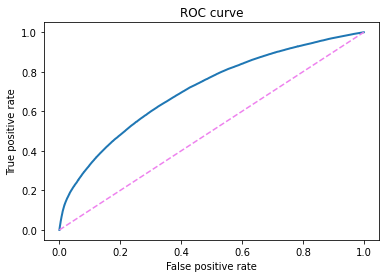

In [87]:
#ROC Graph
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_proba[:,1])
plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve');
print("ROC AUC score = ", metrics.roc_auc_score(y_test, y_pred_proba[:,1]))

<Figure size 7200x14400 with 0 Axes>

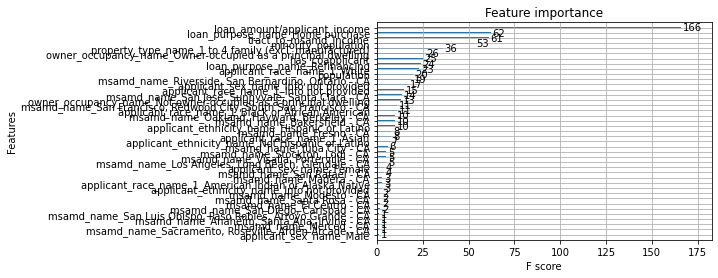

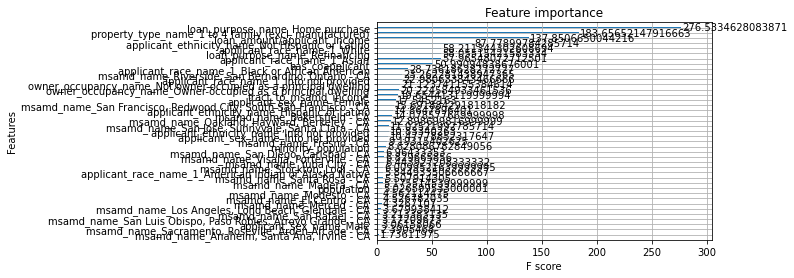

In [88]:
plt.figure(figsize=(100, 200))
xgb.plot_importance(model)
xgb.plot_importance(model, importance_type='gain')
plt.show()

In [89]:
model.get_booster().get_score(importance_type='weight') #extract raw frequency scores

{'loan_purpose_name_Home purchase': 62,
 'has_coapplicant': 25,
 'applicant_race_name_1_Info not provided': 15,
 'applicant_race_name_1_White': 23,
 'property_type_name_1 to 4 family (excl. manufactured)': 36,
 'minority_population': 53,
 'loan_amount/applicant_income': 166,
 'owner_occupancy_name_Owner-occupied as a principal dwelling': 26,
 'loan_purpose_name_Refinancing': 24,
 'applicant_ethnicity_name_Not Hispanic or Latino': 7,
 'owner_occupancy_name_Not owner-occupied as a principal dwelling': 13,
 'applicant_race_name_1_Asian': 8,
 'tract_to_msamd_income': 61,
 'msamd_name_Riverside, San Bernardino, Ontario - CA': 19,
 'applicant_race_name_1_Black or African American': 11,
 'msamd_name_San Diego, Carlsbad - CA': 2,
 'applicant_ethnicity_name_Hispanic or Latino': 10,
 'msamd_name_San Jose, Sunnyvale, Santa Clara - CA': 14,
 'applicant_sex_name_Info not provided': 17,
 'applicant_ethnicity_name_Info not provided': 3,
 'msamd_name_Bakersfield - CA': 10,
 'applicant_sex_name_Male': 

In [90]:
model.get_booster().get_score(importance_type='gain') #extract raw gain scores

{'loan_purpose_name_Home purchase': 276.5334628083871,
 'has_coapplicant': 50.99094838676001,
 'applicant_race_name_1_Info not provided': 22.980633843466666,
 'applicant_race_name_1_White': 58.211344302608694,
 'property_type_name_1 to 4 family (excl. manufactured)': 183.65652147916663,
 'minority_population': 8.628086782849056,
 'loan_amount/applicant_income': 137.8506650044216,
 'owner_occupancy_name_Owner-occupied as a principal dwelling': 20.224584933461536,
 'loan_purpose_name_Refinancing': 58.05515421583334,
 'applicant_ethnicity_name_Not Hispanic or Latino': 87.77899784285714,
 'owner_occupancy_name_Not owner-occupied as a principal dwelling': 21.123741155384614,
 'applicant_race_name_1_Asian': 57.96548072712501,
 'tract_to_msamd_income': 19.654413119999994,
 'msamd_name_Riverside, San Bernardino, Ontario - CA': 23.262281438947365,
 'applicant_race_name_1_Black or African American': 28.73618628272727,
 'msamd_name_San Diego, Carlsbad - CA': 6.96433353,
 'applicant_ethnicity_name